Importing libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn import cluster
import random
import pandas as pd

Creating artificial datasets

In [2]:
def generateDataset(k, dimensions, n_samples):
    X, y_true = make_blobs(n_samples = n_samples, centers = k, n_features= dimensions, cluster_std = 1.1)
    return X

In [3]:
# sizes = [1000, 10000, 100000, 1000000]

# datasetsk3d2 = [generateDataset(3,2,s) for s in sizes]
# datasetsk3d4 = [generateDataset(3,4,s) for s in sizes]
# datasetsk3d8 = [generateDataset(3,8,s) for s in sizes]
# datasetsk9d2 = [generateDataset(9,2,s) for s in sizes]
# datasetsk9d4 = [generateDataset(9,4,s) for s in sizes]
# datasetsk9d8 = [generateDataset(9,8,s) for s in sizes]

Importing real datasets

In [4]:
df = pd.read_csv('../input/gas-sensor-array-under-dynamic-gas-mixtures/ethylene_CO.txt', delim_whitespace=True, skiprows=[0], header=None)
df = df.rename(columns = {0:'Time (seconds)', 1:'CO2 conc (ppm)', 2:'Ethylene conc (ppm)', 3:'Sensor1',
                          4:'Sensor2',5:'Sensor3',6:'Sensor4',7:'Sensor5',8:'Sensor6',9:'Sensor7',
                          10:'Sensor8',11:'Sensor9',12:'Sensor10',13:'Sensor11',14:'Sensor12',15:'Sensor13',
                          16:'Sensor14',17:'Sensor15',18:'Sensor16'})
df = df.iloc[1: , :]
DATA = df.to_numpy()

Choosing random features and sizes of the real dataset

In [5]:
def generateRealDataset(data, dimensions, n_samples):
    n_features = len(data[0])
    n_instances = len(data)
    random_features = np.random.choice(range(n_features), dimensions)
    random_instances = np.random.choice(range(n_instances), n_samples)
    dataset = data[:, random_features]
    dataset = dataset[[random_instances]]
    return dataset

In [6]:
sizes = [4000, 12000, 40000, 120000, 400000]
DSETd2 = [generateRealDataset(DATA,2,s) for s in sizes]
DSETd4 = [generateRealDataset(DATA,4,s) for s in sizes]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


Modified K-Means function for implementation with RPKMeans

In [7]:
class KMeans:
    def __init__(self, k=2, stopping=0.00001, max_iter=300):
        self.k = k
        self.stopping = stopping
        self.max_iter = max_iter
        self.dist_computations = 0
        
    def fit(self, data, init_centroids, weights):
        data = np.array(data)
        self.centroids = {}
        # centroid initialization, if the initial centroids are fed, use them. If there are more data points than
        # clusters, multiply some of the centroids.
        if init_centroids == None:
            if len(data) > self.k:
                for i in range(self.k):
                    self.centroids[i] = data[i]
            else:
                for i in range(len(data)):
                    self.centroids[i] = data[i]
                for i in range(len(data), self.k):
                    self.centroids[i] = np.random.randint(0, len(data))
        elif init_centroids != None and len(data) < self.k:
            for i in range(len(data)):
                self.centroids[i] = init_centroids[i]
            for i in range(len(init_centroids), self.k):
                self.centroids[i] = np.random.randint(0, len(init_centroids))
        else:
            self.centroids = init_centroids
        # K-Means algorithm
        for i in range(self.max_iter):
            error = 0
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []
                
            for i, features in enumerate(data):
                if type(weights) == np.ndarray:
                    # centroid error calculation with respect to the weights
                    distances = [weights[i] * np.linalg.norm(features - self.centroids[centroid]) for centroid in self.centroids]
                else:
                    # centroid error calculation
                    distances = [np.linalg.norm(features - self.centroids[centroid]) for centroid in self.centroids]
                error += np.sum(distances)
                # calculate number of distance computations
                if features.size != 0:
                    self.dist_computations += 1
                # assign points to clusters
                classification = distances.index(min(distances))
                self.classifications[classification].append(features)
            self.error = error
            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

            optimized = True
            
            # move the centroid to the new mean
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                # clustering error calculation, if lower than threshold, kmeans converged
                if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > self.stopping:
                    optimized = False
            if optimized:
                break
    
    def predict(self, data):
        classifications = []
        data = np.array(data)
        # append points to cluster indexes
        for data_point in data:
            distances = [np.linalg.norm(data_point - self.centroids[centroid]) for centroid in self.centroids]
            cluster_index = distances.index(min(distances))
            classifications.append(cluster_index)

        return classifications

RPKMeans algorithm without error computation

In [8]:
class RPKM(KMeans):
    def __init__(self, p=6, k=2, stopping=0.00001, max_iter=300):
        super().__init__(k, stopping, max_iter)
        self.p = p
        self.kmeans = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.kmeansFull = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.centroids = None
    
    # quadtree algorithm
    def partition(self, data):
        if data.size != 0:
            minX = np.min(data[:,0])
            maxX = np.max(data[:,0])
            minY = np.min(data[:,1])
            maxY = np.max(data[:,1])
            middleX = (maxX + minX)/2
            middleY = (maxY + minY)/2
            parts1 = np.array([i for i in data if i[0] <= middleX and i[1] >= middleY])
            parts2 = np.array([i for i in data if i[0] > middleX and i[1] >= middleY])
            parts3 = np.array([i for i in data if i[0] <= middleX and i[1] < middleY])
            parts4 = np.array([i for i in data if i[0] > middleX and i[1] < middleY])
            parts = [parts1, parts2, parts3, parts4]
            res = np.empty(len(parts),object)
            res[:] = parts
            return res
        else:
            return np.array([[], [], [], []])

    def fit(self, data):
        num_points = len(data)
        part_data = [data]
        self.dist_computations = []
        self.representative_ratio = []
        errors = []
        # for different dimensionalities of the data create 2^dim partitions
        for i in range(self.p):
            if len(data[0]) == 2:
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
            elif len(data[0]) == 4:
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
            elif len(data[0]) == 8:
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                
            # calculate the ratio of the representatives in respect to the whole dataset size
            representatives = [ii for ii,d in enumerate(part_data) if d.size != 0]
            self.representative_ratio.append(len(representatives)/num_points)
            means = np.array([np.average(part, axis=0) for part in part_data if part.size != 0])
            weights = np.array([np.size(part)/num_points for part in part_data if part.size != 0])
            self.kmeans.fit(means, self.centroids, weights)
            self.centroids = self.kmeans.centroids
            self.dist_computations.append(self.kmeans.dist_computations)

RPKMeans variation without the 2^dim partitions, instead every iteration 4 partitions are made

In [9]:
class RPKM_fixed_partitions(KMeans):
    def __init__(self, p=6, k=2, stopping=0.00001, max_iter=300):
        super().__init__(k, stopping, max_iter)
        self.p = p
        self.kmeans = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.kmeansFull = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.centroids = None

    def partition(self, data):
        if data.size != 0:
            minX = np.min(data[:,0])
            maxX = np.max(data[:,0])
            minY = np.min(data[:,1])
            maxY = np.max(data[:,1])
            middleX = (maxX + minX)/2
            middleY = (maxY + minY)/2
            parts1 = np.array([i for i in data if i[0] <= middleX and i[1] >= middleY])
            parts2 = np.array([i for i in data if i[0] > middleX and i[1] >= middleY])
            parts3 = np.array([i for i in data if i[0] <= middleX and i[1] < middleY])
            parts4 = np.array([i for i in data if i[0] > middleX and i[1] < middleY])
            parts = [parts1, parts2, parts3, parts4]
            res = np.empty(len(parts),object)
            res[:] = parts
            return res
        else:
            return np.array([[], [], [], []])

    def fit(self, data):
        num_points = len(data)
        part_data = [data]
        self.dist_computations = []
        self.representative_ratio = []
        errors = []
        for i in range(self.p):
            part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
            # calculate the ratio of the representatives in respect to the whole dataset size
            representatives = [ii for ii,d in enumerate(part_data) if d.size != 0]
            self.representative_ratio.append(len(representatives)/num_points)
            means = np.array([np.average(part, axis=0) for part in part_data if part.size != 0])
            weights = np.array([np.size(part)/num_points for part in part_data if part.size != 0])
            self.kmeans.fit(means, self.centroids, weights)
            self.centroids = self.kmeans.centroids
            self.dist_computations.append(self.kmeans.dist_computations)

RPKMeans with error calculation

In [10]:
class RPKM_with_errors(KMeans):
    def __init__(self, p=6, k=2, stopping=0.00001, max_iter=300):
        super().__init__(k, stopping, max_iter)
        self.p = p
        self.kmeans = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.kmeansFull = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.centroids = None

    def partition(self, data):
        if data.size != 0:
            minX = np.min(data[:,0])
            maxX = np.max(data[:,0])
            minY = np.min(data[:,1])
            maxY = np.max(data[:,1])
            middleX = (maxX + minX)/2
            middleY = (maxY + minY)/2
            parts1 = np.array([i for i in data if i[0] <= middleX and i[1] >= middleY])
            parts2 = np.array([i for i in data if i[0] > middleX and i[1] >= middleY])
            parts3 = np.array([i for i in data if i[0] <= middleX and i[1] < middleY])
            parts4 = np.array([i for i in data if i[0] > middleX and i[1] < middleY])
            parts = [parts1, parts2, parts3, parts4]
            res = np.empty(len(parts),object)
            res[:] = parts
            return res
        else:
            return np.array([[], [], [], []])

    def fit(self, data):
        num_points = len(data)
        part_data = [data]
        errors = []
        self.dist_computations = []
        self.representative_ratio = []
        for i in range(self.p):
            if len(data[0]) == 2:
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
            elif len(data[0]) == 4:
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
            elif len(data[0]) == 8:
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
                part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
            representatives = [ii for ii,d in enumerate(part_data) if d.size != 0]
            self.representative_ratio.append(len(representatives)/num_points)
            means = np.array([np.average(part, axis=0) for part in part_data if part.size != 0])
            weights = np.array([np.size(part)/num_points for part in part_data if part.size != 0])
            # standarized error computation
            self.kmeansFull.fit(data, self.centroids, None)
            self.kmeans.fit(means, self.centroids, weights)
            errorRPKM = 0
            
            for features in data:
                distances = [np.linalg.norm(features - self.kmeans.centroids[centroid]) for centroid in self.kmeans.centroids]
                errorRPKM += np.sum(distances)
            
            errorKmeans = self.kmeansFull.error
            std_error = (errorKmeans - errorRPKM)/errorKmeans
            errors.append(std_error)
            self.errors = errors
            self.centroids = self.kmeans.centroids
            self.dist_computations.append(self.kmeans.dist_computations)

RPKMeans with error calculation with 4 partitions each iteration

In [11]:
class RPKM_with_errors_fixed_partitions(KMeans):
    def __init__(self, p=6, k=2, stopping=0.00001, max_iter=300):
        super().__init__(k, stopping, max_iter)
        self.p = p
        self.kmeans = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.kmeansFull = KMeans(k=k, stopping=stopping, max_iter=max_iter)
        self.centroids = None

    def partition(self, data):
        if data.size != 0:
            minX = np.min(data[:,0])
            maxX = np.max(data[:,0])
            minY = np.min(data[:,1])
            maxY = np.max(data[:,1])
            middleX = (maxX + minX)/2
            middleY = (maxY + minY)/2
            parts1 = np.array([i for i in data if i[0] <= middleX and i[1] >= middleY])
            parts2 = np.array([i for i in data if i[0] > middleX and i[1] >= middleY])
            parts3 = np.array([i for i in data if i[0] <= middleX and i[1] < middleY])
            parts4 = np.array([i for i in data if i[0] > middleX and i[1] < middleY])
            parts = [parts1, parts2, parts3, parts4]
            res = np.empty(len(parts),object)
            res[:] = parts
            return res
        else:
            return np.array([[], [], [], []])

    def fit(self, data):
        num_points = len(data)
        part_data = [data]
        errors = []
        self.dist_computations = []
        self.representative_ratio = []
        for i in range(self.p):
            part_data = np.hstack([self.partition(d) for d in part_data if np.shape(self.partition(d)) != (4,0)])
            representatives = [ii for ii,d in enumerate(part_data) if d.size != 0]
            self.representative_ratio.append(len(representatives)/num_points)
            means = np.array([np.average(part, axis=0) for part in part_data if part.size != 0])
            weights = np.array([np.size(part)/num_points for part in part_data if part.size != 0])
            # standarized error computation
            self.kmeansFull.fit(data, self.centroids, None)
            self.kmeans.fit(means, self.centroids, weights)
            errorRPKM = 0
            
            for features in data:
                distances = [np.linalg.norm(features - self.kmeans.centroids[centroid]) for centroid in self.kmeans.centroids]
                errorRPKM += np.sum(distances)
            
            errorKmeans = self.kmeansFull.error
            std_error = (errorKmeans - errorRPKM)/errorKmeans
            errors.append(std_error)
            self.errors = errors
            self.centroids = self.kmeans.centroids
            self.dist_computations.append(self.kmeans.dist_computations)

Demonstration of the algorithms

In [12]:
X = DSETd2[1]

192000


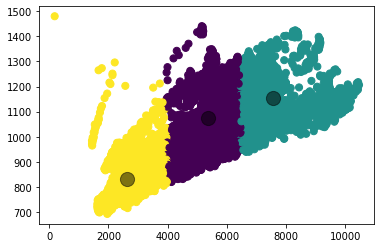

In [13]:
model = KMeans(k=3)
model.fit(X,None,None)
print(model.dist_computations)
plt.scatter(X[:, 0], X[:, 1], c=model.predict(X), s=50, cmap='viridis')
centers = np.array([i[1] for i in list(model.centroids.items())])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

[[2626.210526    830.49845468]
 [7564.34771019 1154.21861437]
 [5352.52119945 1072.63604295]]


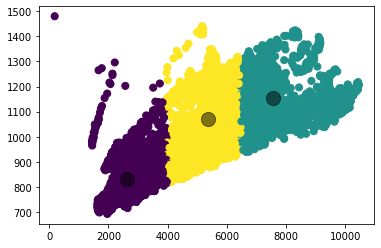

In [14]:
model = cluster.KMeans(3)
model.fit(X)
print(model.cluster_centers_)
plt.scatter(X[:, 0], X[:, 1], c=model.predict(X), s=50, cmap='viridis')
centers = np.array([i for i in list(model.cluster_centers_)])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

20053


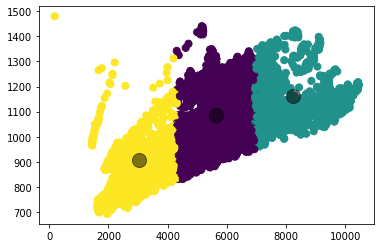

In [15]:
model = RPKM(k=3)
model.fit(X)
print(np.sum(model.dist_computations))
plt.scatter(X[:, 0], X[:, 1], c=model.predict(X), s=50, cmap='viridis')
centers = np.array([i[1] for i in list(model.centroids.items())])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

[0.0901893929779601, -0.09109377999736741, -0.11192024080581398, -0.08028550359954326, -0.05530283173729222, -0.025139345676049432]


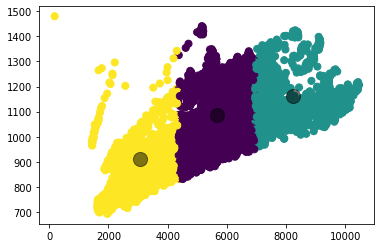

In [16]:
model = RPKM_with_errors_fixed_partitions(k=3)
model.fit(X)
print(model.errors)
plt.scatter(X[:, 0], X[:, 1], c=model.predict(X), s=50, cmap='viridis')
centers = np.array([i[1] for i in list(model.centroids.items())])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

Plot results

In [17]:
def plots_computations(datasets, sizes, k, filename, mode):
    rpkm1 = []
    rpkm2 = []
    rpkm3 = []
    rpkm4 = []
    rpkm5 = []
    rpkm6 = []
    kmeans = []
    for d in datasets:
        if mode == 'normal':
            model = RPKM(k=k)
            model1 = KMeans(k=k)
        if mode == 'fixed_partitions':
            model = RPKM_fixed_partitions(k=k)
            model1 = KMeans(k=k)
        model.fit(d)
        model1.fit(d,None,None)
        kmeans.append(model1.dist_computations)
        rpkm1.append(model.dist_computations[0])
        rpkm2.append(model.dist_computations[1])
        rpkm3.append(model.dist_computations[2])
        rpkm4.append(model.dist_computations[3])
        rpkm5.append(model.dist_computations[4])
        if len(model.dist_computations) > 5:
            rpkm6.append(model.dist_computations[5])
    print('fitting done')
    fig = plt.figure(figsize=(10,5))
    plt.plot(sizes, rpkm1,linestyle='--', marker='o')
    plt.plot(sizes, rpkm2,linestyle='--', marker='o')
    plt.plot(sizes, rpkm3,linestyle='--', marker='o')
    plt.plot(sizes, rpkm4,linestyle='--', marker='o')
    plt.plot(sizes, rpkm5,linestyle='--', marker='o')
    
    if len(model.dist_computations) > 5:
        plt.plot(sizes, rpkm6,linestyle='--', marker='o')
        plt.plot(sizes, kmeans,linestyle='--', marker='o')
        plt.legend(['RPKM1', 'RPKM2', 'RPKM3', 'RPKM4', 'RPKM5','RPKM6', 'KMeans'])
    else:
        plt.plot(sizes, kmeans,linestyle='--', marker='o')
        plt.legend(['RPKM2', 'RPKM3', 'RPKM4', 'RPKM5', 'RPKM6', 'KMeans'])
    plt.xscale('log')
    plt.yscale('log')
    fig.savefig(filename)

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fitting done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


fitting done


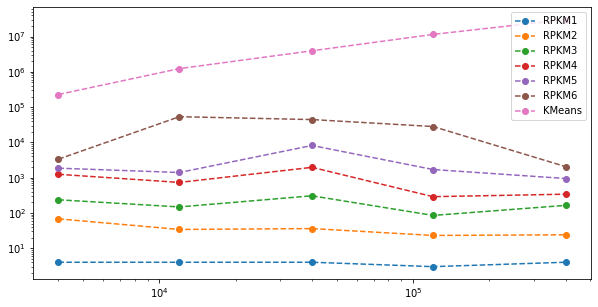

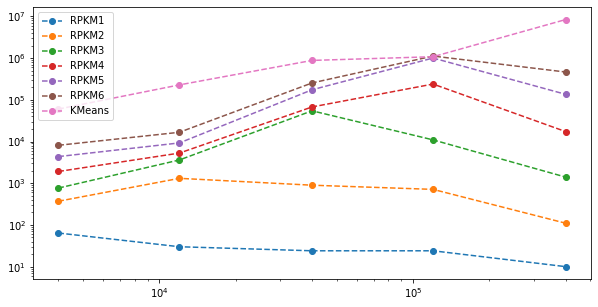

In [18]:
# plots_computations(DSETd2, sizes, 3, 'DSETd2k3-computations', 'normal')
plots_computations(DSETd2, sizes, 9, 'DSETd2k9-computations', 'normal')
plots_computations(DSETd4, sizes, 3, 'DSETd4k3-computations', 'normal')
# plots_computations(DSETd4, sizes, 9, 'DSETd4k9-computations', 'normal')

In [19]:
def plots_ratios(datasets,sizes, k, filename, mode):
    steps = [1,2,3,4,5,6]
    fig = plt.figure(figsize=(10,5))
    for d in datasets:
        if mode =='normal':
            model = RPKM(k=k)
        if mode =='fixed_partitions':
            model = RPKM_fixed_partitions(k=k)
        model.fit(d)
        ratios = model.representative_ratio
        plt.plot(steps, model.representative_ratio,linestyle='--', marker='o')
    plt.legend([str(s) for s in sizes])
    fig.savefig(filename)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


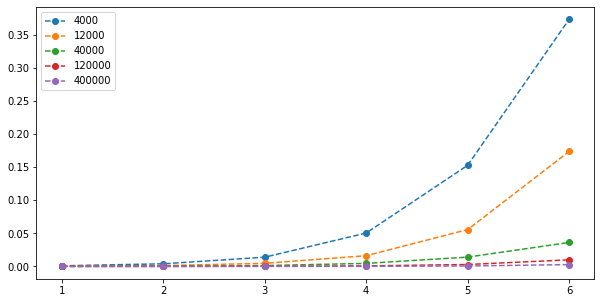

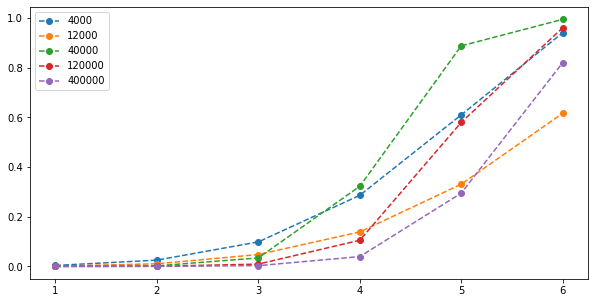

In [20]:
# plots_ratios(DSETd2, sizes, 3, 'DSETd2k3-ratios', 'normal')
plots_ratios(DSETd2, sizes, 9, 'DSETd2k9-ratios', 'normal')
plots_ratios(DSETd4, sizes, 3, 'DSETd4k3-ratios', 'normal')
# plots_ratios(DSETd4, sizes, 9, 'DSETd4k9-ratios', 'normal')

In [21]:
def plots_errors(datasets, sizes, k, filename, mode):
    steps = [1,2,3,4,5,6]
    fig = plt.figure(figsize=(10,5))
    for d in datasets:
        if mode =='normal':
            model = RPKM_with_errors(k=k)
        if mode =='fixed_partitions':
            model = RPKM_with_errors_fixed_partitions(k=k)
        model.fit(d)
        plt.plot(steps, model.errors,linestyle='--', marker='o')
    
    plt.legend([str(s) for s in sizes])
    fig.savefig(filename)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


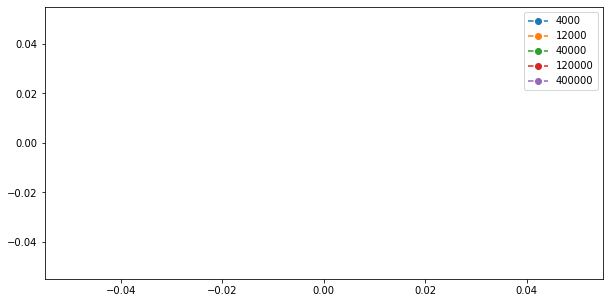

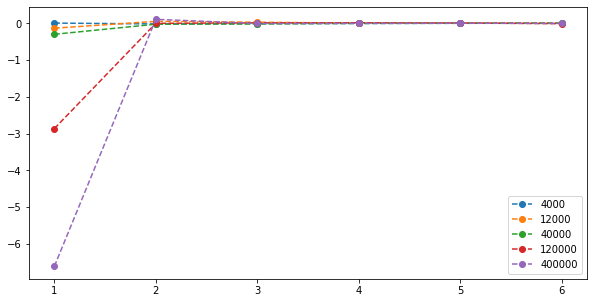

In [22]:
# plots_errors(DSETd2, sizes, 3, 'DSETd2k3-errors', 'normal')
plots_errors(DSETd2, sizes, 9, 'DSETd2k9-errors', 'normal')
plots_errors(DSETd4, sizes, 3, 'DSETd4k3-errors', 'normal')
# plots_errors(DSETd4, sizes, 9, 'DSETd4k9-errors', 'normal')